# Run TensorFlow on a PolygonArray

Show ten polygons, along with their actual and TensorFlow-predicted number of vertices

In [1]:
import import_ipynb
import numpy as np
import pandas as pd
from pandas import DataFrame as DF, Series as Ser
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from os import sys
#for d in sys.path:
#    print(d)
#!pwd

import polygon
import polygonarray, polygonsmall
from polygon import Polygon
from polygonarray import PolygonArray

2024-12-10 23:31:55.056249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
n_polys_train = 60000
n_polys_test = 10000

ar_train = PolygonArray(n_polys_train)
ar_test = PolygonArray(n_polys_test)

train_images = \
    np.array([ps.img for ps in ar_train.polys]) # need np.array to compute shape
train_labels = np.array([ps.nverts for ps in ar_train.polys])

In [17]:
edgesize = train_images[0].shape[0]
print("Edgesize:", edgesize)

Edgesize: 50


In [18]:
test_images = np.array([ps.img for ps in ar_test.polys])
test_labels = np.array([ps.nverts for ps in ar_test.polys])
print(len(test_labels))

10000


In [19]:
# See https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb
model = tf.keras.models.Sequential([
  tf.keras.layers.Input((edgesize, edgesize)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       320,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,289 (1.23 MB)

 Trainable params: 321,289 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

[`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) is useful for stacking layers where each layer has one input [tensor](https://www.tensorflow.org/guide/tensor) and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the [`Input`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Input), [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), and [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers.

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.


In [20]:
predictions = model(train_images[:1]).numpy()
predictions

array([[ 0.7335303 ,  0.8012849 ,  1.1463068 , -1.3440256 , -1.106513  ,
         0.0100512 ,  0.28523934, -2.1516285 ,  1.9159708 ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class:

In [21]:
probabilities = tf.nn.softmax(predictions).numpy()
np.argmax(probabilities)

8

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:

In [22]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [23]:
loss_fn(train_labels[:1], predictions).numpy()

3.957155

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [24]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

### Get model's predictions

Use the `Model.fit` method to adjust model parameters and minimize loss:

In [25]:
f = model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3518 - loss: 1.5697
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7263 - loss: 0.6955
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8334 - loss: 0.4729
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8640 - loss: 0.3761
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8877 - loss: 0.3144
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9109 - loss: 0.2593
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9208 - loss: 0.2288
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9315 - loss: 0.2047
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9278 - loss: 0.2045
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9382 - loss: 0.1777


In [26]:
# Verify predicted minimum, maximum numbers of vertices
label_predict_probas = model.predict(test_images)
predicted_nverts = np.array([np.argmax(p) for p in label_predict_probas])
print(f'{"No. Images:":22s}{len(predicted_nverts):8d}')
print(f'{"Minimum No. Vertices:":22s}{predicted_nverts.min():8d}')
print(f'{"Maximum No. Vertices:":22s}{predicted_nverts.max():8d}')
print(predicted_nverts)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
No. Images:              10000
Minimum No. Vertices:        3
Maximum No. Vertices:        8
[5 6 8 ... 6 3 5]


#### Show the numbers of vertices, predicted vs. actual

In [27]:
df = pd.concat([Ser(predicted_nverts), Ser(test_labels)], axis=1)
df.columns=['Predicted', 'Actual']
df['Match'] = (df['Predicted'] == df['Actual'])
df['Match'].sum()

8541

#### For a sample of the test images, match the numbers of vertices, actual vs. predicted

We want 10 consecutive images, chosen to contain at least 2 mismatches.

In [28]:
mismatch_indices = (df['Match'].to_numpy() == False).nonzero()[0]

# Select only mismatch_indices where 2 are within 10 of each other
mismatches_ge_2 = np.array([mismatch_indices[i] if \
    mismatch_indices[i+1] - mismatch_indices[i] < 10 \
    else 0 for i in range(len(mismatch_indices)-1)])
firstindex = mismatch_indices[mismatches_ge_2.nonzero()[0][0]]

# Get indices of 10 consecutive images
display_sample = np.arange(firstindex, firstindex + 10, 1)
display_sample

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

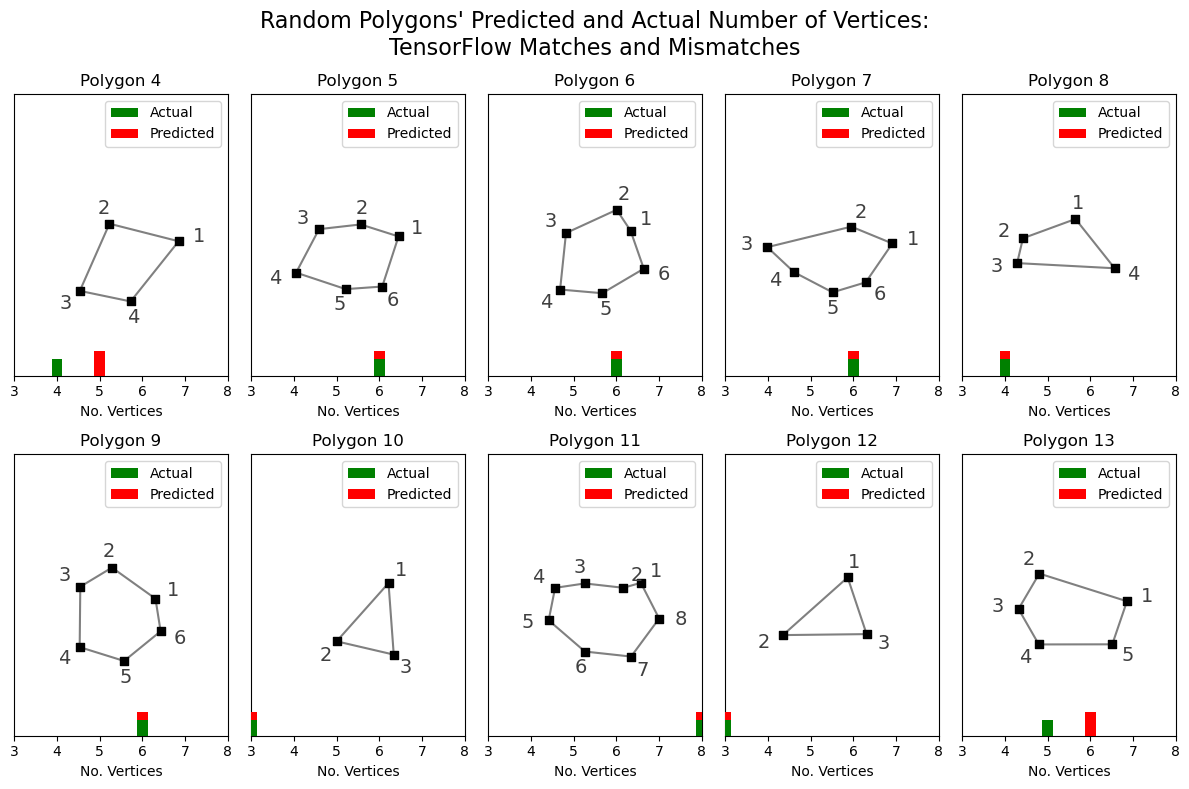

In [29]:
def ShowPolysWithModelPredictions(test_images, display_sample, predicted_nverts):
    '''Show polygons with predicted and actual number of vertices'''  
        
    nrows, ncols = (2, 5)
    xticks_array = np.array([-2 + i * 4 / 5 for i in range(6)])
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), layout='tight')
    fig.suptitle("Random Polygons' Predicted and Actual Number of Vertices:\n"
                 "TensorFlow Matches and Mismatches", fontsize=16)
    for i in range(10):
        ax=axs[i//ncols][i%ncols]
        ax.bar(nverts_to_x(ar_test.polys[display_sample[i]].nverts), 0.4, 
               width=0.2, bottom=-3, color='green', zorder=5, label="Actual")
        ax.bar(nverts_to_x(predicted_nverts[display_sample[i]]), 0.6, 
           bottom=-3, color='red', zorder=4, label="Predicted", width=0.2)
        ar_test.polys[display_sample[i]].draw(ax)
        ax.set_ylim(-3, 4)
        ax.set_xticks(xticks_array, np.arange(3, 9))
        ax.set_yticks([])
        ax.set_xlabel("No. Vertices")
        ax.set_title("Polygon " + str(display_sample[i]))
        ax.legend()
    plt.show()
    
def nverts_to_x(numverts):
    '''convert no. vertices to x-coordinates'''
    return 0.8 * numverts - 4.4
        
ShowPolysWithModelPredictions(test_images, display_sample, predicted_nverts)